# Toy models of Superposition

In this notebook we recreate some of the results of the 2022 Anthropic paper "Toy models of Superposition". One of the interesting findings of that paper is neural networks are able to store many more features than their width might seem to suggest.

The simple model we study here is an autoencoder that maps a vector $x \in \mathbb{R}^n$ into a lower dimensional vector $h \in \mathbb{R}^m$ and then recovers it. We will train the autoencoder to recover this vector as accurately as possible, and inspect which neuron in the $m$-dimensional hidden layer are activated for a given vector.

In [87]:
# import packages
from dataclasses import dataclass
from tqdm import trange

import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns


@dataclass
class Config:
    n_features: int = 20
    n_hidden: int = 5
    n_instances: int = 1
    batch_size: int = 20
    sparsity: float = 0

class Model():
    def __init__(self, config, importance=None, nonlinear = False):
        # store hyperparameters
        self.config = config
        self.importance = importance if importance is not None else torch.ones()
        self.nonlinear = nonlinear
        # initialise weights and biases
        self.weights = torch.randn(size=(config.n_features, config.n_hidden), requires_grad=True) 
        self.bias = torch.zeros((1,config.n_features), requires_grad=True)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        x = x @ self.weights
        x = x @ torch.transpose(self.weights, 0, 1) + self.bias
        x = F.relu(x) if self.nonlinear else x
        return x
    
    def generate_batch(self):
        batch = torch.rand((self.config.batch_size, self.config.n_features))
        mask = torch.rand(batch.shape) < self.config.sparsity
        batch[mask] = 0
        return batch

    def train(self, lr=0.1, n_steps=10**4):
        loss_hist = []
        for i in trange(n_steps):    
            # generate batch
            x = self.generate_batch()

            # forward pass
            y = self.forward(x)
        
            # compute loss, weighted by the importance of the features
            loss = torch.mean((x-y)**2 * self.importance)
        
            # backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()

            # update
            for p in self.parameters:
                p.data += -lr * p.grad
                # p.grad.zero()

            if i % 100 == 0:
                loss_hist.append(loss.log10().item())
            
        
        # store training loss
        self.loss_hist = loss_hist
        

        
        
    


The input features $x_i$ will be set to zero with a probability of $S_i = S$, but otherwise they will be drawn uniformly from $[0, 1]$. This parameter $S$ is the sparsity and determines how 'sparse' the data is.

100%|██████████| 200000/200000 [00:22<00:00, 8894.91it/s]


<Axes: >

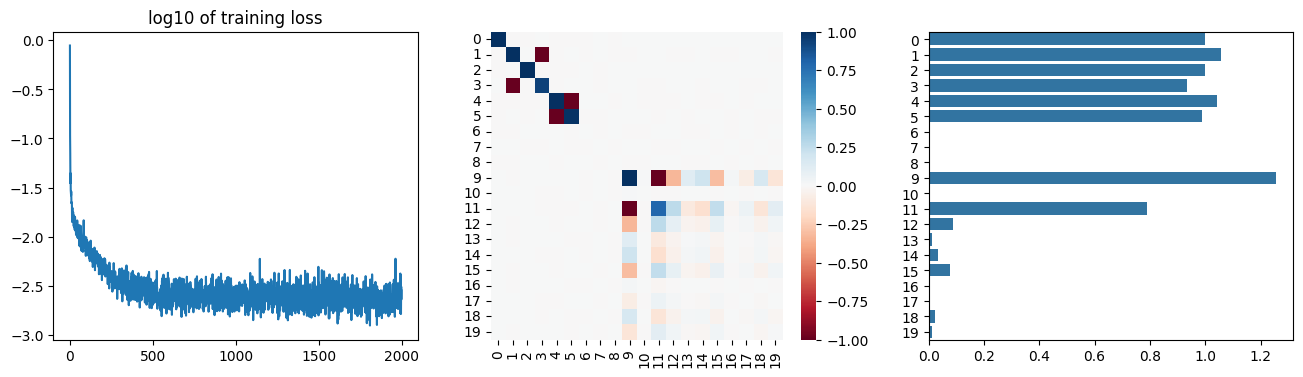

In [88]:
#  set hyperparameters
config = Config(
    n_features = 20,
    n_hidden = 5,
    n_instances = 1,
    batch_size = 50,
    sparsity =  0.7,
 )

# initalize model
model = Model(
    config=config,
    importance=0.7 ** torch.arange(config.n_features),
    nonlinear=True,
)

# train the model
model.train(lr=0.1, n_steps = 2*10**5)

# get weights
wwt = model.weights @ torch.transpose(model.weights, 0, 1) 
wwt = wwt.detach().numpy()

# plot
fig, axs = plt.subplots(ncols = 3, figsize=(16, 4))

axs[0].plot(model.loss_hist)
axs[0].set_title("log10 of training loss")

sns.heatmap(wwt,  cmap='RdBu', vmin=-1, vmax=1, ax=axs[1])
sns.barplot(wwt.diagonal(), orient='h', ax=axs[2])




In [72]:
model.bias.round(decimals=2)

tensor([[-0.0000, -0.0000, -0.0000, 0.0000, 0.2200, 0.4200, 0.4900, 0.4700, 0.4500,
         0.4500, 0.4500, 0.4400, 0.4300, 0.3900, 0.4400, 0.4500, 0.4400, 0.5800,
         0.4100, 0.1600]], grad_fn=<RoundBackward1>)